In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import tensorflow.keras as tfk
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, Input, Concatenate, Flatten, Reshape
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_regression
import wandb
import datetime

gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)

for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
    
    
rng = np.random.default_rng(12345)

2024-04-29 19:38:54.633096: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-29 19:38:54.633134: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-29 19:38:54.635263: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-29 19:38:54.645060: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-29 19:38:56.949282: W tensorflow/comp

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [1]:
def check_wide(value):
    if value[1] < -2.5*value[0]+1.15:
        return False
    if value[1] > -2.5*value[0]+1.9:
        return False
    return True

def check_narrow(value):
    if value[0] < .15 or value[0] > .45:
        return False
    if value[1] < .5 or value[1] > 1.3:
        return False
    if value[1] < -2.5*value[0]+1.3:
        return False
    if value[1] > -2.5*value[0]+1.8:
        return False
    return True


def make_cosmogrid(value):
    wide = check_wide(value)
    narrow = check_narrow(value)
    if not wide:
        return False
    if not narrow:
        return np.random.choice([True, False], p=[.5, .5])
    return True

N_train=73644, N_val=9095, N_test=6252



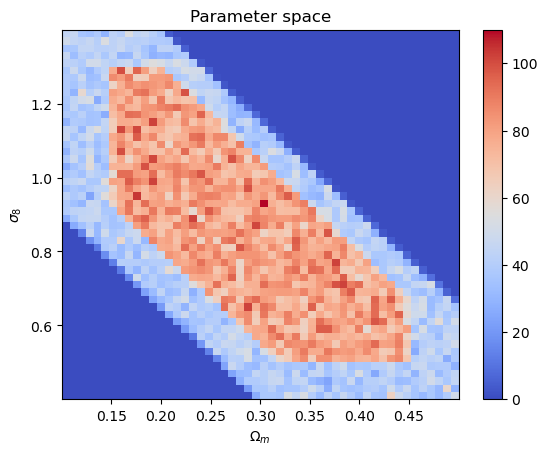

In [3]:
min_scale = 6 
nsims = 200000

savepath = '../data/run2/'

theta = np.load(savepath + 'theta.npy')[:nsims] #[Om, s8, w, n_s, Ob, H0, ia , dnz1, dnz2, dnz3, dnz4, mpb1, mpb2, mpb3, mpb4, id]
theta_fixed = theta[:,2::1]
theta = theta[:,:2]


xip = np.load(savepath + 'xip.npy')[:nsims]
xim = np.load(savepath + 'xim.npy')[:nsims]

xi = np.concatenate((xip[:,:,min_scale:,None], xim[:,:,min_scale:,None]), axis=3)
xi_flat = xi.reshape(xi.shape[0], -1)


base_path_fiducial = '../data/CosmoGrid/fiducial/'
xip_fiducial = np.load(base_path_fiducial + 'xip.npy')[:,:,:,min_scale:].reshape(800,-1)
xim_fiducial = np.load(base_path_fiducial + 'xim.npy')[:,:,:,min_scale:].reshape(800,-1)
xi_fiducial = np.concatenate((xip_fiducial, xim_fiducial), axis=1)


cov = np.cov(xi_fiducial.T)
noise = rng.multivariate_normal(np.zeros(xi_fiducial.shape[1]), cov, xi_flat.shape[0])
xi_flat += noise

x = xi_flat


cosmogrid_inds = np.apply_along_axis(make_cosmogrid, 1, theta)
x = x[cosmogrid_inds]        
theta = theta[cosmogrid_inds]

plt.hist2d(theta[:,0], theta[:,1], bins=50, density=False, cmap='coolwarm', norm='linear')
plt.title("Parameter space")
plt.xlabel(r"$\Omega_m$")
plt.ylabel(r"$\sigma_8$")
plt.colorbar()

y = theta[:,1] * np.sqrt(theta[:,0] / 0.3)
y_mean = y.mean(axis=0)
y_std = np.max(np.abs(y - y_mean))

val_inds = np.random.choice(np.arange(y.shape[0]), size=int(y.shape[0]*0.1), replace=False)
test_inds = np.random.choice(np.arange(y.shape[0]), size=int(y.shape[0]*0.1), replace=False)


y_val = (y[val_inds] - y_mean) / y_std
x_val = x[val_inds]
y_test = y[test_inds]
x_test = x[test_inds]
y_train = (np.delete(y, [val_inds, test_inds], axis=0) - y_mean) / y_std
x_train = np.delete(x, [val_inds, test_inds], axis=0)


x_test = x_test[np.apply_along_axis(check_narrow, 1, theta[test_inds])]
y_test = y_test[np.apply_along_axis(check_narrow, 1, theta[test_inds])]

s8_min = y_test.min()
s8_max = y_test.max()


print(f"N_train={x_train.shape[0]}, N_val={x_val.shape[0]}, N_test={x_test.shape[0]}\n")



In [4]:
def build_model():
    
    regularizer = tfk.regularizers.L1L2(l1=0.0, l2=0.0)
    regularizer_b = tfk.regularizers.L1L2(l1=0.0, l2=0.0)
    
    input = Input(shape=(x.shape[1],), name="Input")
    y = input
    y = BatchNormalization(name='BatchNorm_1')(y)
    y = Dense(128, activation='LeakyReLU', kernel_regularizer=regularizer, bias_regularizer=regularizer_b, name='Dense_128_1')(y)
    y = Dense(128, activation='LeakyReLU', kernel_regularizer=regularizer, bias_regularizer=regularizer_b, name='Dense_128_2')(y)
    y = Dense(128, activation='tanh', kernel_regularizer=regularizer, bias_regularizer=regularizer_b, name='Dense_128_3')(y)
    y = Dense(64, activation='tanh', kernel_regularizer=regularizer, bias_regularizer=regularizer_b, name='Dense_64_1')(y)
    y = Dense(16, activation='tanh', kernel_regularizer=regularizer, bias_regularizer=regularizer_b, name='Dense_16_1')(y)
    y = Dense(1, activation='tanh', kernel_regularizer=regularizer, bias_regularizer=regularizer_b, name='Output')(y)
    
    return Model(inputs=input, outputs=y)

model = build_model()

loss = tf.keras.losses.MeanSquaredError()
model.summary()

checkpoint = ModelCheckpoint(filepath='../models/model.keras', save_best_only=True, save_weights_only=True, monitor='val_loss', verbose=2)
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
callbacks = [EarlyStopping(patience=30, monitor='val_loss', restore_best_weights=True, verbose=2),
            checkpoint,
            tensorboard,
            ReduceLROnPlateau(patience=20, monitor='val_loss', verbose=2, factor=0.1, restore_best_weights=True),
            ReduceLROnPlateau(patience=10, monitor='loss', verbose=2, factor=0.1, restore_best_weights=True),
            ]


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 180)]             0         
                                                                 
 BatchNorm_1 (BatchNormaliz  (None, 180)               720       
 ation)                                                          
                                                                 
 Dense_128_1 (Dense)         (None, 128)               23168     
                                                                 
 Dense_128_2 (Dense)         (None, 128)               16512     
                                                                 
 Dense_128_3 (Dense)         (None, 128)               16512     
                                                                 
 Dense_64_1 (Dense)          (None, 64)                8256      
                                                             

2024-04-29 19:39:06.375695: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79087 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:5b:00.0, compute capability: 8.0


In [5]:
wandb.init(project='reverse_emulator', sync_tensorboard=True)


for lr in np.logspace(-8, -3, 6)[:-1]:
    optimizer_init = tf.keras.optimizers.SGD(learning_rate=lr)
    model.compile(optimizer=optimizer_init, loss=loss)
    model.fit(x_train, y_train, epochs=1, batch_size=128, callbacks=checkpoint, validation_data=(x_val, y_val))


optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3, beta_1=0.9, beta_2=0.999, epsilon=1e-09, jit_compile=True, use_ema=False, ema_overwrite_frequency=150)
model.compile(optimizer=optimizer, loss=loss)
model.fit(x_train, y_train, epochs=10000, batch_size=64, callbacks=callbacks, validation_data=(x_val, y_val))


model.load_weights('../models/model.keras')
wandb.run.summary["state"] = "completed"
wandb.finish()  


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: d-gebauer. Use `wandb login --relogin` to force relogin


2024-04-29 19:39:26.536556: I external/local_xla/xla/service/service.cc:168] XLA service 0x7ef319715910 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-29 19:39:26.536587: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A100 80GB PCIe, Compute Capability 8.0
2024-04-29 19:39:26.572171: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
I0000 00:00:1714412366.713280   84954 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


576/576 [==============================] - ETA: 0s - loss: 0.1817
Epoch 1: val_loss improved from inf to 0.17778, saving model to ../models/model.keras
575/576 [============================>.] - ETA: 0s - loss: 0.1816
Epoch 1: val_loss improved from 0.17778 to 0.17777, saving model to ../models/model.keras
572/576 [============================>.] - ETA: 0s - loss: 0.1817
Epoch 1: val_loss improved from 0.17777 to 0.17772, saving model to ../models/model.keras
576/576 [==============================] - ETA: 0s - loss: 0.1815
Epoch 1: val_loss improved from 0.17772 to 0.17764, saving model to ../models/model.keras
571/576 [============================>.] - ETA: 0s - loss: 0.1815
Epoch 1: val_loss improved from 0.17764 to 0.17762, saving model to ../models/model.keras
576/576 [==============================] - 7s 8ms/step - loss: 0.1815 - val_loss: 0.1776
Epoch 1/10000


2024-04-29 19:40:02.545837: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-04-29 19:40:02.642602: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-29 19:40:02.642644: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-29 19:40:02.644534: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-29 19:40:04.145810: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


1146/1151 [============================>.] - ETA: 0s - loss: 0.1819

wandb: WARNING When using several event log directories, please call `wandb.tensorboard.patch(root_logdir="...")` before `wandb.init`



Epoch 1: val_loss did not improve from 0.17762
1151/1151 [==============================] - 13s 8ms/step - loss: 0.1819 - val_loss: 0.1778 - lr: 0.0010
Epoch 2/10000
1149/1151 [============================>.] - ETA: 0s - loss: 0.1818
Epoch 2: val_loss did not improve from 0.17762
1151/1151 [==============================] - 10s 8ms/step - loss: 0.1818 - val_loss: 0.1780 - lr: 0.0010
Epoch 3/10000
1148/1151 [============================>.] - ETA: 0s - loss: 0.1818
Epoch 3: val_loss did not improve from 0.17762
1151/1151 [==============================] - 10s 8ms/step - loss: 0.1818 - val_loss: 0.1778 - lr: 0.0010
Epoch 4/10000
1146/1151 [============================>.] - ETA: 0s - loss: 0.1666
Epoch 4: val_loss improved from 0.17762 to 0.08664, saving model to ../models/model.keras
1151/1151 [==============================] - 10s 8ms/step - loss: 0.1662 - val_loss: 0.0866 - lr: 0.0010
Epoch 5/10000
1150/1151 [============================>.] - ETA: 0s - loss: 0.0692
Epoch 5: val_loss im

global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
train/epoch_loss,█▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
validation/epoch_loss,█▂▂▂▁▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation/evaluation_loss_vs_iterations,█▂▂▂▁▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation/global_step,▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▅▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁
global_step,209482
state,completed
train/epoch_loss,0.01253
train/global_step,181
validation/epoch_loss,0.00828


196/196 [==============================] - 0s 1ms/step


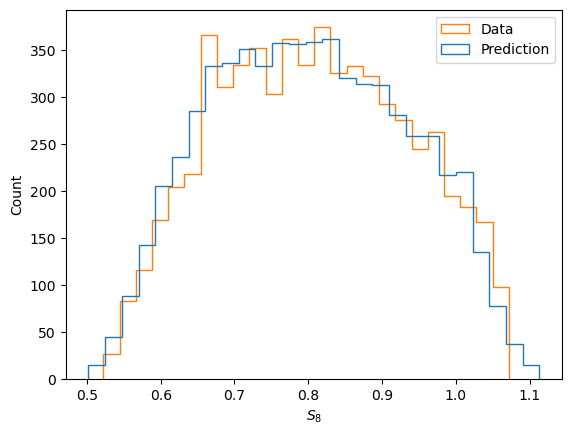

In [7]:
pred = model.predict(x_test)[:,0] * y_std + y_mean

_ = plt.hist(y_test, bins='auto', histtype='step', color='C1', label='Data')
_ = plt.hist(pred[:], bins='auto', histtype='step', color='C0', alpha=1, label='Prediction')

plt.xlabel(r'$S_8$')
plt.ylabel('Count')
plt.legend()

In [8]:
corr = np.corrcoef(y_test, pred)[1,0]
std = np.std(y_test - pred)
mae = np.mean(np.abs(y_test - pred))
outlier = np.where(np.abs(y_test - pred) > 0.05)[0].shape[0] / y_test.shape[0]

print(f"Correlation Coefficients:   {corr:.3f}")
print(f"Mean Absolute Error:        {mae:.3f}")
print(f"Larger than 0.05:           {outlier:.3f}")
print(f"Standard Deviation:         {std:.3f}")


Correlation Coefficients:   0.965
Mean Absolute Error:        0.028
Larger than 0.05:           0.154
Standard Deviation:         0.035


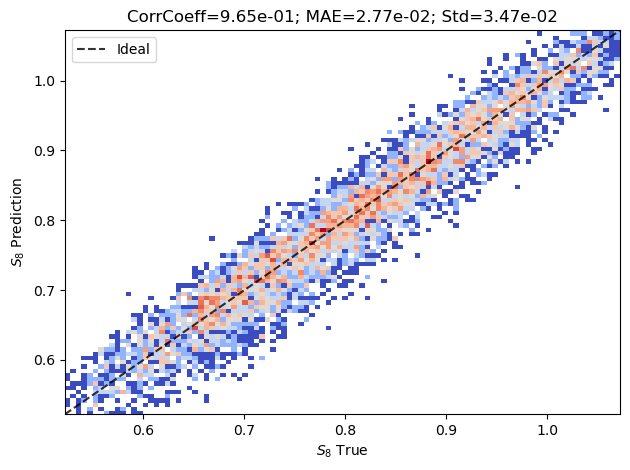

In [9]:
_ = plt.hist2d(y_test, pred, bins=100, cmap='coolwarm', norm='log')
plt.title(f"CorrCoeff={corr:.2e}; MAE={mae:.2e}; Std={std:.2e}", fontsize=12)
plt.xlabel(r'$S_8$ True')
plt.ylabel(r'$S_8$ Prediction')
plt.plot([s8_min, s8_max], [s8_min, s8_max], c='k', ls='--', lw=1.5, alpha=.8 ,label='Ideal')
plt.xlim(s8_min, s8_max)
plt.ylim(s8_min, s8_max)
plt.legend()
plt.tight_layout()